In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import savemat # for saving data to .mat file
import sys

In [2]:
# path to functions
sys.path.append(r"/home/illich/SeriesDistance/SeriesDistance Python NEU/functions Python NEU/")

# import functions
from f_smooth_DP import f_smooth_DP
from f_ReplaceEqualNeighbours import f_ReplaceEqualNeighbours
from f_FindSplitPoints import f_FindSplitPoints
from f_PlotInput import f_plot_input
from f_CoarseGraining_SD_Continuous import f_coarse_graining_continuous
from f_PlotConnectedSeries import f_PlotConnectedSeries
from f_PlotSDErrors_OnePanel import f_PlotSDErrors_OnePanel

orginal obs: var: 69.171188618656, # extremes: 1990, diff(obs)=3408.547
orginal sim: var: 52.86143165392219, # extremes: 500, diff(sim)=2680.4173
smoothed obs: var: 69.03954912923022, # extremes: 246, diff(obs)=2957.607
smoothed sim: var: 52.86143165392219, # extremes: 500, diff(sim)=2680.4173


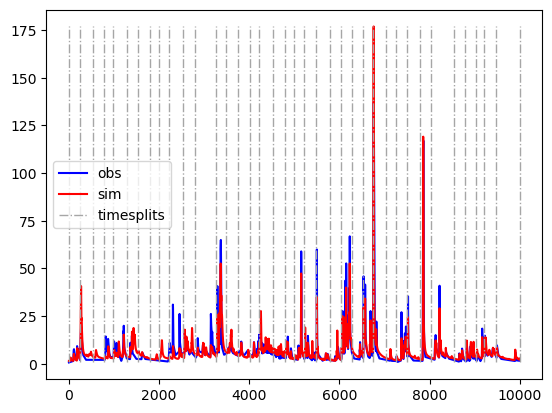

time series split 0 of 37
selected step # initial conditions
time series split 1 of 37
time series split 2 of 37
time series split 3 of 37
selected step # initial conditions
time series split 4 of 37


/home/illich/SeriesDistance/SeriesDistance Python NEU/functions Python NEU/f_normalize.py:7: RuntimeWarning: invalid value encountered in divide
  k = (k - np.nanmin(k)) / (np.nanmax(k) - np.nanmin(k))


selected step # initial conditions
time series split 5 of 37
selected step # initial conditions
time series split 6 of 37
time series split 7 of 37
time series split 8 of 37
time series split 9 of 37
selected step # initial conditions
time series split 10 of 37
selected step # initial conditions
time series split 11 of 37
selected step # initial conditions
time series split 12 of 37
selected step # initial conditions
time series split 13 of 37
selected step # initial conditions
time series split 14 of 37
selected step # initial conditions
time series split 15 of 37
selected step # initial conditions
time series split 16 of 37
selected step # initial conditions
time series split 17 of 37
selected step # initial conditions
time series split 18 of 37
selected step # initial conditions
time series split 19 of 37
selected step # initial conditions
time series split 20 of 37
selected step # initial conditions
time series split 21 of 37
selected step # initial conditions
time series split 22 

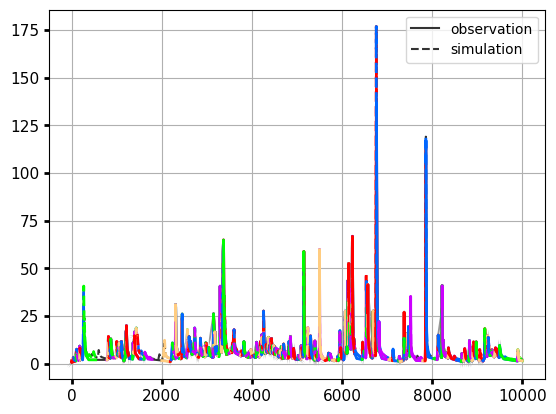

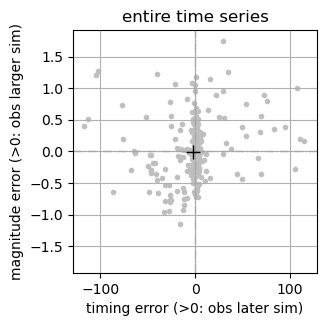

In [3]:
#  ====================================================================== 
#                 Series Distance Analysis (Continuous Mode) 
#  ======================================================================
#  last modification 16.08.2016

# This development release of the SeriesDistance (SD) method is applicable to continuous 
# observed (obs) and simulated (sim) discharge time series. It outputs a 2d-error 
# distribution for the entire time series. Contrary to the event based method the 
# continuous version does not differentiate periods of low-flow from periods of events.  
# Nevertheless, the entire hydrograph is classified into rising and falling limbs. The 
# interpretation of these classes is however only meaningful if the periods of low-flow 
# do not cover a significant portion of the hydrograph. Note: For plotting,
# the error distributions for rise and fall are combined.

# Further information:
# Seibert, S. P., Ehret, U., and Zehe, E., 2016: Disentangling timing and amplitude errors in streamflow simulations, Hydrol. Earth Syst. Sci.
# Ehret, U., Zehe, E., 2011. Series distance - An intuitive metric to quantify hydrograph similarity in terms of occurrence, amplitude and timing of hydrological events. Hydrol. Earth Syst. Sci. 15, 877–896. doi:10.5194/hess-15-877-2011

# Dependencies
# All required functions are stored in folder \functions

# Input (ascii format)
#  - obs: [n,1] matrix with equidistant and NaN-free time series of observed discharge data.
#  - sim: [n,1] matrix with equidistant and NaN-free time series of simulated discharge data. 
#  - timeseries_splits: [n,1] optional matrix with points in time where the 'obs' and 'sim' time series will be split to increase computational speed.
#     It must include the first and the last timestep of 'obs' and 'sim'. E.g. if 'obs' and 'sim' are [1100,1],
#     then 'timeseries_splits' could be (1, 250, 800, 1100)

# Parameters are explained and specified in the parameter block

# Outputs (all stored within a single binary file .mat)
#  - obs:              observed discharge (smoothed)
#  - sim:              simulated discharge
#  - segs_obs_opt_all: optimized segments in obs
#  - segs_sim_opt_all: optimized segments in sim
#  - connectors:       SD connectors
#  - e_sd_q_all:       SD magnitude errors for entire time series
#  - e_sd_t_all:       SD timing errors for entire time series
#  - parameters:       all parameters, i.e. error_model, objective function weights, smoothing parameters,  
#                       are included in the outputfile

# Start from scratch
os.system('clear')  # for Linux and macOS
# os.system('cls')  # for Windows
plt.close('all')  # close all figures

# specify paths and parameters, read inputs
# os.chdir('ADD_YOUR_PATH_HERE')  # set working directory

########################################################### mein Working Directory ###########################################################
os.chdir(r"/home/illich/SeriesDistance/")
########################################################### mein Working Directory ###########################################################

# read input
obs = np.genfromtxt('data/HOST_timeseries.csv', delimiter=';', skip_header=1, usecols=2, max_rows=10000)
sim = np.genfromtxt('data/HOST_timeseries.csv', delimiter=';', skip_header=1, usecols=3, max_rows=10000)

# # print some information
# print('Input data SD_Analysis_Continuous:')
# # print("obs: ", obs)
# print('type obs: ', type(obs))
# print('dtype obs: ', obs.dtype)
# print('shape obs: ', obs.shape)
# print('\n')
# # print("sim: ", sim)
# print('type sim: ', type(sim))
# print('dtype sim: ', sim.dtype)
# print('shape sim: ', sim.shape)
# print('\n')

# output filenames
outfile = './results/output.mat'

# smoothing options
smooth_flag = True         # smooth both obs and sim (default=True)
nse_smooth_limit = 0.99    # specifies degree of smoothing according to NSE criterion (default=0.99)

# specification of the magnitude error model
error_model = 'relative'  # 'relative' or 'standard'; (default='relative')

# options for time series splitting:
timeseries_split_by_user = False  # 'true': time series splits provided by user in ascii file. 'false': splits will be placed by the program (default=False)
split_frequency = 250             # only required if timeseries_split_by_user=False: this is the default distance between 2 splits (default=500)

# parametrization of the objective function 
weight_nfc = 1/7   # weights number of re-assigned hydrological cases (default= 1)    
weight_rds = 1/7   # weights the importance of the re-assigned segments (default=1) 
weight_sdt = 5/7   # weights the SD timing error component (default=5)
weight_sdv = 0     # weights the SD magnitude error component (default=0)

# set plot flags 
pf_input = True                   # plots input time series ('obs' and 'sim')
pf_segs_cons_entireTS = True      # plots obs, sim, colour-coded pairs of matching segments, SeriesDistance connectors for the entire time series
pf_errordist = True               # plots SeriesDistance error distributions 

# Data manipulations and pre-processing

# smooth if required (default=True)
if smooth_flag:
    obs_org = obs.copy()
    sim_org = sim.copy()
    obs, sim = f_smooth_DP(obs, sim, nse_smooth_limit)

# # print some information
# print('\n')
# print('Data after smoothening:')
# # print("obs: ", obs)
# print('type obs: ', type(obs))
# print('dtype obs: ', obs.dtype)
# print('shape obs: ', obs.shape)
# print('\n')
# # print("sim: ", sim)
# print('type sim: ', type(sim))
# print('dtype sim: ', sim.dtype)
# print('shape sim: ', sim.shape)
# print('\n')

# replace identical neighbouring values to avoid problems with assignment of unique peaks and valleys
obs = f_ReplaceEqualNeighbours(obs)
sim = f_ReplaceEqualNeighbours(sim)

# # print some information
# print('Data after f_replace_equal_neighbours:')
# # print("obs: ", obs)
# print('type obs: ', type(obs))
# print('dtype obs: ', obs.dtype)
# print('shape obs: ', obs.shape)
# print('\n')
# # print("sim: ", sim)
# print('type sim: ', type(sim))
# print('dtype sim: ', sim.dtype)
# print('shape sim: ', sim.shape)
# print('\n')

# Define time series split points to improve coarse-graining performance
if not timeseries_split_by_user:
    timeseries_splits = f_FindSplitPoints(obs, sim, split_frequency)  # find split points if they are not provided by the user       
else:
    timeseries_splits = np.genfromtxt('data/HOST_ts_splits.csv', delimiter=';')  # read splits defined by user.
# print('timeseries_splits: ', timeseries_splits)
# print('\n')

# plot input data
if pf_input:
    f_plot_input([], obs, [], [], sim, [], [], timeseries_splits)  # show time series splits

# cleanup
del smooth_flag, nse_smooth_limit, pf_input, timeseries_split_by_user, split_frequency

# Apply coarse-graining and the SD method to the entire time series 
# note: contrary to the event based method both, the coarse-graining and the SD calculation 
# take place in the same function here due to the splitting of the time series. To this end 
# the splitting is solved in a simplistic way and does not support separating the 
# coarse-graining and SD calculation as in the event-based version.

# apply coarse graining and SD calculation: determines optimal level of segment aggregation for entire time series and applies SD to it
segs_obs_opt_all, segs_sim_opt_all, connectors, e_sd_t_all, e_sd_q_all = f_coarse_graining_continuous(
    obs, sim, timeseries_splits, weight_nfc, weight_rds, weight_sdt, weight_sdv, error_model)

# plot time series with optimized segments and connectors in an own figure

# print('Input f_PlotConnectedSeries:')
# print('segs_obs_opt_all: ', segs_obs_opt_all)
# print('segs_obs_opt_all type: ', type(segs_obs_opt_all))
# print('segs_obs_opt_all dtype: ', type(segs_obs_opt_all[0]))
# print('\n')
# print('segs_sim_opt_all: ', segs_sim_opt_all)
# print('segs_sim_opt_all type: ', type(segs_sim_opt_all))
# print('segs_sim_opt_all dtype: ', type(segs_sim_opt_all[0]))
# print('\n')
# print('connectors: ', connectors)
# print('connectors type: ', type(connectors))
# print('connectors dtype: ', type(connectors[0]))
# print('\n')

if pf_segs_cons_entireTS:
    f_PlotConnectedSeries(obs, segs_obs_opt_all, sim, segs_sim_opt_all, connectors)

# code hinzugefügt zu Übersetzung
e_sd_q_all_new = []
for list in e_sd_q_all:
    for element in list:
        e_sd_q_all_new.append(element)

e_sd_t_all_new = []
for list in e_sd_t_all:
    for element in list:
        e_sd_t_all_new.append(element)
        
# plot 2d-error distributions
if pf_errordist:
    f_PlotSDErrors_OnePanel(e_sd_t_all_new, e_sd_q_all_new)
    # f_PlotSDErrors_OnePanel(e_sd_t_all, e_sd_q_all)

# # save output
# savemat(outfile, {
#     'obs': obs,
#     'sim': sim,
#     'segs_obs_opt_all': segs_obs_opt_all,
#     'segs_sim_opt_all': segs_sim_opt_all,
#     'connectors': connectors,
#     'e_sd_t_all': e_sd_t_all,
#     'e_sd_q_all': e_sd_q_all,
#     'weight_nfc': weight_nfc,
#     'weight_rds': weight_rds,
#     'weight_sdt': weight_sdt,
#     'weight_sdv': weight_sdv,
#     'error_model': error_model
# })